In [1]:
import os.path
import re
import sys
import tarfile
import time
import multiprocessing as mp
import itertools

import tensorflow.python.platform
from six.moves import urllib
import numpy as np
import tensorflow as tf
import h5py
import glob
import cPickle as pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.python.platform import gfile

from run_inference import predict_star, predict
import pandas as pd
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def create_graph(pb_file):
    """"Creates a graph from saved GraphDef file and returns a Graph object.
    Returns:
    Graph holding the trained Inception network.
    """
    model_filename = pb_file
    with gfile.FastGFile(model_filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        tf.import_graph_def(graph_def, name='')

In [ ]:
#create_graph("/data/retrain_manualtags1/output_graphfinal.pb")
create_graph("/data/classify_image_graph_def.pb")
sess = tf.Session()

In [4]:
params = pickle.load(open("/data/datenet_decorations_outputs/output_params7600.pkl", 'r'))  # use 7600 for decorations; top-1 = 65.5%
fw = params["final_weights"]
fb = params["final_biases"]
print fb.shape
print fw.shape

(7,)
(2048, 7)


In [7]:
# I currently don't know what labels correspond to each of the 7 elements; will figure out

In [5]:
# from http://www.socouldanyone.com/2013/03/converting-grayscale-to-rgb-with-numpy.html
def to_rgb(im):
    w, h = im.shape[:2]
    ret = np.empty((w, h, 3), dtype=np.uint8)
    ret[:, :, 0] = im
    ret[:, :, 1] = im
    ret[:, :, 2] = im
    return ret

# from http://www.socouldanyone.com/2013/03/converting-grayscale-to-rgb-with-numpy.html
def to_rgbs(im):
    n, w, h = im.shape[:3]
    ret = np.empty((n, w, h, 3), dtype=np.uint8)
    ret[:, :, :, 0] = im[:,:,:,0]
    ret[:, :, :, 1] = im[:,:,:,0]
    ret[:, :, :, 2] = im[:,:,:,0]
    return ret

# from https://gist.github.com/yusugomori/4462221
def softmax(x):
    e = np.exp(x - np.max(x))  # prevent overflow
    if e.ndim == 1:
        return e / np.sum(e, axis=0)
    else:  
        return e / np.array([np.sum(e, axis=1)]).T  # ndim = 2

In [2]:
# read in hdf5 file
image_hdf5 = h5py.File('/data/image_data.hdf5','r')
(image_metadata, book_metadata, image_to_idx) = pickle.load(open("/data/all_metadata_1M_tags.pkl", 'r'))

In [3]:
# get a list of images to look at for each date
date_to_images = {}  # each value is a dictionary with {filename --> idx}
for folder in glob.glob("/data/decorations_by_date/*/"):
    era = os.path.basename(folder[:-1])
    imgs = glob.glob(folder + "/*.jpg")
    fns = np.random.choice([os.path.basename(i)[:-4] for i in imgs], 1000, False)
    idxs = [image_to_idx[fn] for fn in fns]
    date_to_images[era] = dict(zip(fns, idxs))
print [(x, len(date_to_images[x].keys())) for x in date_to_images]

[('1870-1889', 1000), ('1750-1799', 1000), ('post-1890', 1000), ('pre-1700', 1000), ('1700-1749', 1000), ('1800-1849', 1000), ('1850-1869', 1000)]


## Pool3 and softmax

In [38]:
date_to_pool3_scores = {}
date_to_softmax_scores = {}
pool3_tensor = sess.graph.get_tensor_by_name('pool_3:0')

for era in date_to_images:
    print era
    date_to_pool3_scores[era] = {}
    date_to_softmax_scores[era] = {}

    for img in date_to_images[era]:
        idx = date_to_images[era][img]
        
        chk = idx/5000
        chunk = "Chunk" + str(chk)
        i = idx % 5000
        if chunk not in image_hdf5: continue

        a = [to_rgb(image_hdf5[chunk][i][:,:,0])]
        predictions = sess.run(pool3_tensor, {'ExpandDims:0': a})[:,0,0,:]
        date_to_pool3_scores[era][img] = predictions[0]
        
        scores = np.dot(predictions, fw) + fb
        scores = np.array([softmax(scores[j]) for j in range(scores.shape[0])])
        date_to_softmax_scores[era][img] = scores[0]

pickle.dump((date_to_pool3_scores, date_to_softmax_scores), open("/data/decorations_by_date/pool3_softmax_scores.pkl", 'w'))

1870-1889
1750-1799
post-1890
pre-1700
1700-1749
1800-1849
1850-1869


In [59]:
date_to_pool3_scores

{'1700-1749': {'002049260_0_000300_1_': array([ 0.1585463 ,  0.69297051,  0.12304182, ...,  0.20347384,
          0.02283513,  0.1269314 ], dtype=float32),
  '000308745_0_000007_1_': array([ 0.1525996 ,  0.25626445,  0.04333899, ...,  0.09573131,
          0.03679884,  0.09266222], dtype=float32),
  '001489232_0_000215_1_': array([ 0.17563885,  0.15946268,  0.08006583, ...,  0.44981536,
          0.0034972 ,  0.00789644], dtype=float32),
  '000308745_0_000357_1_': array([  6.48826838e-01,   6.80388093e-01,   2.17244506e-01, ...,
           2.78042080e-05,   6.45555481e-02,   4.20284458e-03], dtype=float32),
  '003952966_0_000035_2_': array([ 0.05645999,  0.05197226,  0.03351097, ...,  0.38777453,
          0.        ,  0.45755616], dtype=float32),
  '001379898_0_000219_1_': array([ 1.23577738,  0.86674929,  0.36077294, ...,  0.00225827,
          0.01418623,  0.        ], dtype=float32),
  '002782482_0_000217_1_': array([ 0.11187464,  0.2912609 ,  0.13547458, ...,  0.82308477,
        

In [40]:
(date_to_pool3_scores, date_to_softmax_scores) = pickle.load(open("/data/decorations_by_date/pool3_softmax_scores.pkl", 'r'))

In [23]:
len(date_to_pool3_scores["pre-1700"])

1000

2048

In [30]:
# learn the order of labels
date_to_softmax_arr = {}
for era in date_to_softmax_scores:
    date_to_softmax_arr[era] = pd.DataFrame.from_dict(date_to_softmax_scores[era])
#date_to_softmax_arr = pd.DataFrame.from_dict(date_to_softmax_arr)

In [13]:
labels = ["1850-1869", "1800-1849", "1870-1889", "1750-1799", "1700-1749", "pre-1700", "post-1890"]
labels_sorted = ["pre-1700", "1700-1749", "1750-1799", "1800-1849", "1850-1869", "1870-1889", "post-1890"]
labels_idx_pos = [labels_sorted.index(i) for i in labels]
date_to_softmax_arr = date_to_softmax_arr[labels_sorted]
date_to_softmax_arr = date_to_softmax_arr.iloc[labels_idx_pos]
date_to_softmax_arr

,pre-1700,1700-1749,1750-1799,1800-1849,1850-1869,1870-1889,post-1890
4,0.038627,0.680799,0.132965,0.052746,0.019910,0.010990,0.021508
3,0.011621,0.083071,0.684972,0.054662,0.018775,0.009832,0.009446
5,0.923422,0.061518,0.022232,0.010662,0.007170,0.002244,0.008356
2,0.002569,0.022062,0.013654,0.071375,0.162190,0.317262,0.211979
1,0.011241,0.078444,0.080790,0.528406,0.146388,0.083443,0.096569
0,0.006641,0.039132,0.041221,0.162318,0.437587,0.235120,0.191871
6,0.005881,0.034974,0.024166,0.119831,0.207981,0.341109,0.460271


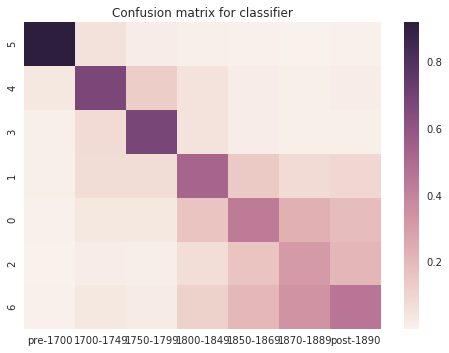

In [105]:
sns.heatmap(date_to_softmax_arr)  # we can see that the closer the dates the more likely things are to cluster
plt.title("Confusion matrix for classifier")

In [72]:
# heatmap it, rank neurons from low->high to high->low
date_to_pool3_arr = {}
for era in date_to_softmax_scores:
    date_to_pool3_arr[era] = pd.DataFrame.from_dict(date_to_pool3_scores[era]).mean(axis=1)
date_to_pool3_arr = pd.DataFrame.from_dict(date_to_pool3_arr)
date_to_pool3_arr = date_to_pool3_arr[labels_sorted]

[0, 0, 0, 0, 0]

In [70]:
# Luda: Get Images with the top activations for each neuron
# Data structure: array of neurons, each is an array of image_name:tag pairs with the highest activations from the pool-3layer
import operator

def get_top_activations(activations, num_neurons, k):
    labels = ["1850-1869", "1800-1849", "1870-1889", "1750-1799", "1700-1749", "pre-1700", "post-1890"]
    res = []
    for i in range(0, num_neurons):
        all_activations = {}
        #get top image_name:tag pairs for each neuron 
        for era in activations:
            for img_name in activations[era]:
                scores = activations[era][img_name]
                all_activations[(img_name, era)] = scores[i]
        res.append(sorted(all_activations.items(), key=operator.itemgetter(1), reverse=True)[:k])
    return res

top_images = get_top_activations(date_to_pool3_scores, 2048, 5)
print top_images[:5]

[[(('002167334_11_000026_3_', 'post-1890'), 2.0299096), (('001613136_0_000332_1_', '1870-1889'), 1.859188), (('002802722_0_000172_1_', 'pre-1700'), 1.6408042), (('000795252_0_000354_1_', '1800-1849'), 1.634481), (('002802722_0_000127_1_', 'pre-1700'), 1.6257583)], [(('001972297_07_000051_1_', 'post-1890'), 2.025769), (('002150812_0_000538_1_', '1850-1869'), 1.7858142), (('003520629_02_000079_1_', '1800-1849'), 1.6622168), (('003759501_0_000126_1_', 'post-1890'), 1.4863414), (('003990028_0_000284_1_', '1870-1889'), 1.4081345)], [(('003870771_0_000197_1_', '1800-1849'), 0.97694707), (('003525289_0_000009_1_', '1750-1799'), 0.93012911), (('001142504_01_000206_1_', '1800-1849'), 0.91762745), (('000404520_0_000012_1_', '1870-1889'), 0.88129115), (('000366784_0_000176_1_', '1750-1799'), 0.84955096)], [(('002121080_0_000218_1_', '1870-1889'), 1.3252484), (('001959398_0_000109_1_', 'post-1890'), 1.2960569), (('003222432_01_000198_1_', '1870-1889'), 1.1247065), (('004159563_05_000154_2_', '1800

66     0.476398
11     0.490512
126    0.495621
541    0.600390
376    0.692793
dtype: float32


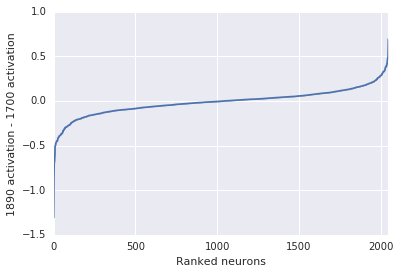

In [76]:
diff = date_to_pool3_arr["post-1890"] - date_to_pool3_arr["pre-1700"]
diff.sort_values(inplace=True)
sns.tsplot(diff)
plt.xlabel("Ranked neurons")
plt.ylabel("1890 activation - 1700 activation")

For Neuron 66:
1750-1799
3.09008


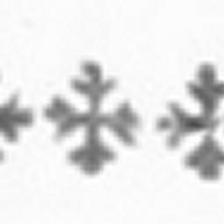

1700-1749
2.99017


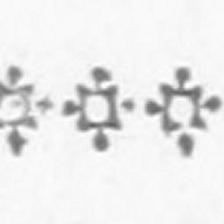

1700-1749
2.90082


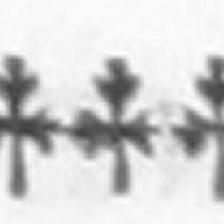

1800-1849
2.89187


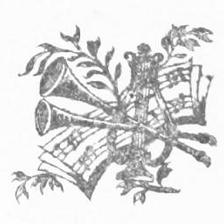

1750-1799
2.85756


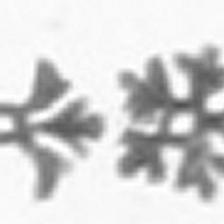

For Neuron 11:
1870-1889
2.86772


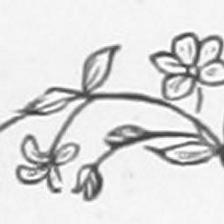

1750-1799
2.79479


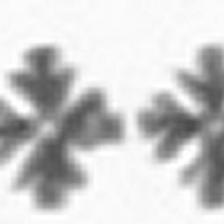

1870-1889
2.54573


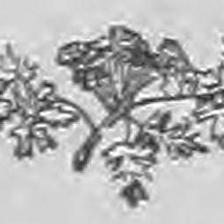

1750-1799
2.53867


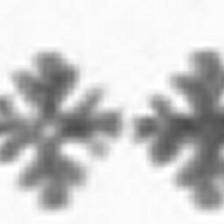

1750-1799
2.52419


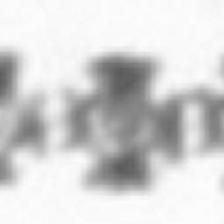

For Neuron 126:
post-1890
3.2958


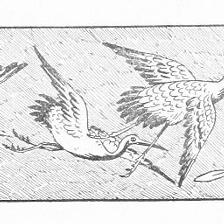

1700-1749
3.15192


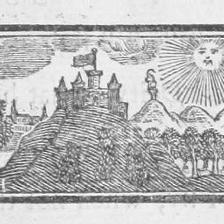

1800-1849
3.04571


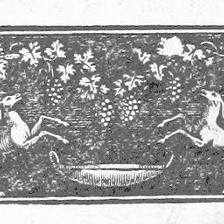

1850-1869
3.03525


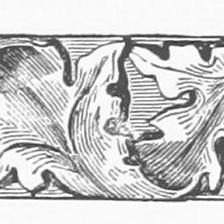

1800-1849
2.89629


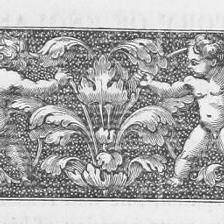

For Neuron 541:
post-1890
5.28536


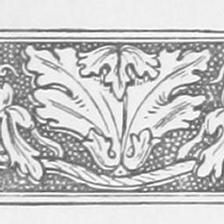

post-1890
5.25006


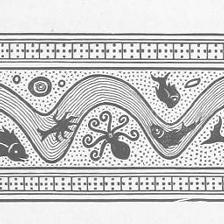

post-1890
5.15121


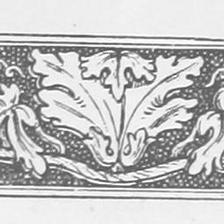

1870-1889
5.12753


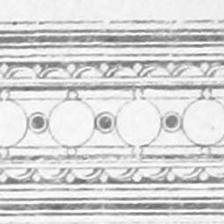

post-1890
4.87972


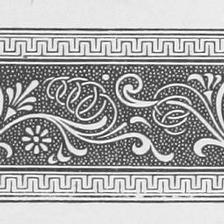

For Neuron 376:
1870-1889
6.82254


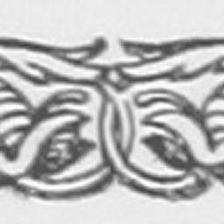

1800-1849
6.74843


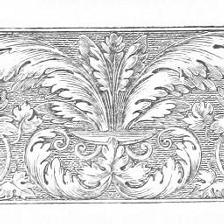

1700-1749
6.46595


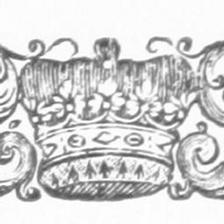

1800-1849
6.43096


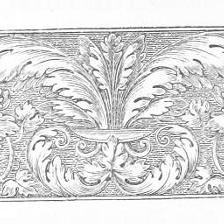

1700-1749
6.35138


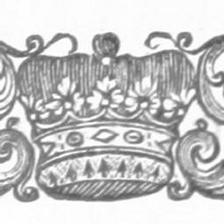

In [94]:
# Get a few neurons we are interested in
top_neurons = diff[-5:].index.values
bottom_neurons = diff[:5].index.values

from IPython.display import Image, display

# Get the top 5 images for each of the neurons we're interested in
for n in top_neurons:
    print "For Neuron " + str(n) + ":"
    for (img_name, era), score in top_images[n]:
        base_dir = "/data/decorations_by_date/" + era + "/"
        fn = base_dir + img_name + ".jpg"
        print era
        print score
        display(Image(filename=fn))
    
    


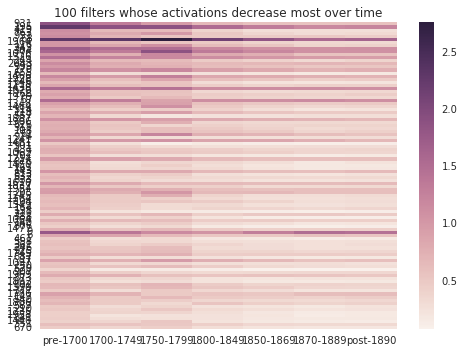

In [74]:
sns.heatmap(date_to_pool3_arr.iloc[diff.index[:100]])
plt.title("100 filters whose activations decrease most over time")

In [17]:
date_to_pool3_arr.iloc[diff.index[:5]]

NameError: name 'diff' is not defined

In [16]:
date_to_pool3_arr[:5]

,pre-1700,1700-1749,1750-1799,1800-1849,1850-1869,1870-1889,post-1890
0,0.386918,0.328074,0.269452,0.356902,0.353453,0.414705,0.412649
1,0.388230,0.382586,0.226817,0.354891,0.383094,0.419080,0.424801
2,0.108662,0.110459,0.084545,0.105945,0.101316,0.086497,0.090295
3,0.073293,0.064896,0.049227,0.082284,0.097951,0.147355,0.148084
4,0.085226,0.106548,0.073544,0.148587,0.129773,0.120003,0.143530


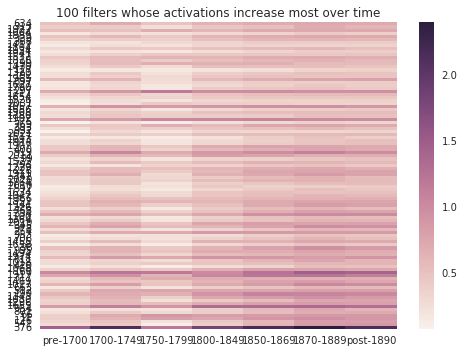

In [73]:
sns.heatmap(date_to_pool3_arr.iloc[diff.index[-100:]])
plt.title("100 filters whose activations increase most over time")

In [83]:
date_to_pool3_arr.iloc[diff.index[-5:]]

,pre-1700,1700-1749,1750-1799,1800-1849,1850-1869,1870-1889,post-1890
66,0.409132,0.716593,0.916283,0.841083,0.870123,0.880397,0.885531
11,0.404151,0.650432,0.814286,0.762257,0.917762,0.978023,0.894662
126,0.343460,0.497795,0.235274,0.457614,0.603215,0.830672,0.839081
541,0.285812,0.456036,0.128858,0.410659,0.635929,0.851639,0.886203
376,1.470577,2.134178,1.214491,1.828239,2.172730,2.405102,2.163369


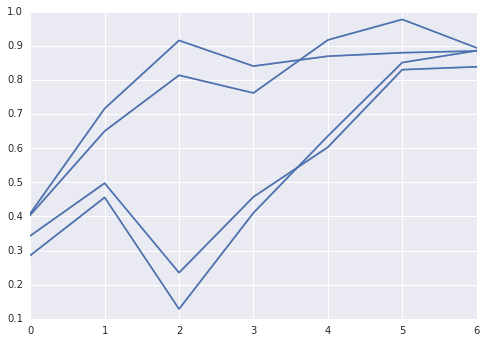

In [90]:
# another way to look at trends

sns.tsplot(date_to_pool3_arr.iloc[diff.index[-5:]].iloc[0])
sns.tsplot(date_to_pool3_arr.iloc[diff.index[-5:]].iloc[1])
sns.tsplot(date_to_pool3_arr.iloc[diff.index[-5:]].iloc[2])
sns.tsplot(date_to_pool3_arr.iloc[diff.index[-5:]].iloc[3])

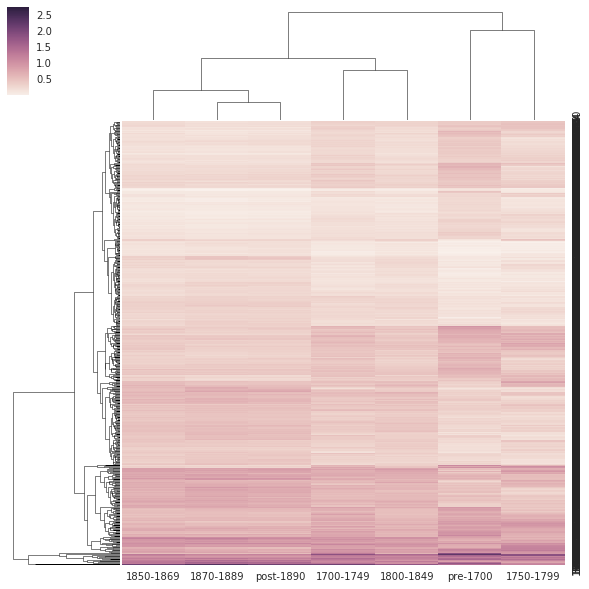

In [106]:
# can do clustering so that we can see which neurons are most activated for each era
date_to_pool3_arr_sig = pd.concat((date_to_pool3_arr.iloc[diff.index[-300:]], date_to_pool3_arr.iloc[diff.index[:300]]))
sns.clustermap(date_to_pool3_arr_sig)

## Layer 0

In [107]:
# what other layers are there that we could look at?

# reconstruct date_to_images
date_to_images = {}
for era in date_to_softmax_scores:
    date_to_images[era] = {}
    for img in date_to_softmax_scores[era]:
        idx = image_to_idx[img]
        date_to_images[era][img] = idx

In [129]:
date_to_conv0_scores = {}
conv0_tensor = sess.graph.get_tensor_by_name('conv:0')

for era in date_to_images:
    print era
    date_to_conv0_scores[era] = {}

    for img in date_to_images[era]:
        idx = date_to_images[era][img]
        
        chk = idx/5000
        chunk = "Chunk" + str(chk)
        i = idx % 5000
        if chunk not in image_hdf5: continue

        a = [to_rgb(image_hdf5[chunk][i][:,:,0])]
        predictions = sess.run(conv0_tensor, {'ExpandDims:0': a})
        date_to_conv0_scores[era][img] = predictions.sum(axis=(0,1,2))

pickle.dump(date_to_conv0_scores, open("/data/decorations_by_date/conv0_scores.pkl", 'w'))

1870-1889
1750-1799
post-1890
pre-1700
1700-1749
1800-1849
1850-1869


In [122]:
conv0_tensor.eval(session=sess).shape

(1, 149, 149, 32)

In [128]:
date_to_conv0_scores['1870-1889']['000359422_0_000208_4_'].shape

(32,)

In [130]:
# heatmap it, rank neurons from low->high to high->low
date_to_conv0_scores = pickle.load(open("/data/decorations_by_date/conv0_scores.pkl", 'r'))
date_to_conv0_arr = {}
for era in date_to_conv0_scores:
    date_to_conv0_arr[era] = pd.DataFrame.from_dict(date_to_conv0_scores[era]).mean(axis=1)
date_to_conv0_arr = pd.DataFrame.from_dict(date_to_conv0_arr)
date_to_conv0_arr = date_to_conv0_arr[labels_sorted]

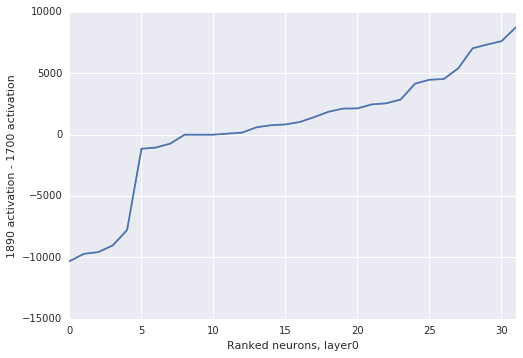

In [133]:
diff_conv0 = date_to_conv0_arr["post-1890"] - date_to_conv0_arr["pre-1700"]
diff_conv0.sort_values(inplace=True)
sns.tsplot(diff_conv0)
plt.xlabel("Ranked neurons, layer0")
plt.ylabel("1890 activation - 1700 activation")

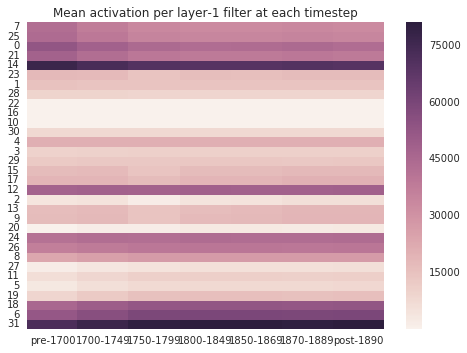

In [151]:
sns.heatmap(date_to_conv0_arr.ix[diff_conv0.index])
plt.title("Mean activation per layer-1 filter at each timestep")

## Conv 4

In [137]:
date_to_conv4_scores = {}
conv4_tensor = sess.graph.get_tensor_by_name('conv_4:0')

for era in date_to_images:
    print era
    date_to_conv4_scores[era] = {}

    for img in date_to_images[era]:
        idx = date_to_images[era][img]
        
        chk = idx/5000
        chunk = "Chunk" + str(chk)
        i = idx % 5000
        if chunk not in image_hdf5: continue

        a = [to_rgb(image_hdf5[chunk][i][:,:,0])]
        predictions = sess.run(conv4_tensor, {'ExpandDims:0': a})
        date_to_conv4_scores[era][img] = predictions.sum(axis=(0,1,2))

pickle.dump(date_to_conv4_scores, open("/data/decorations_by_date/conv4_scores.pkl", 'w'))

1870-1889
1750-1799
post-1890
pre-1700
1700-1749
1800-1849
1850-1869


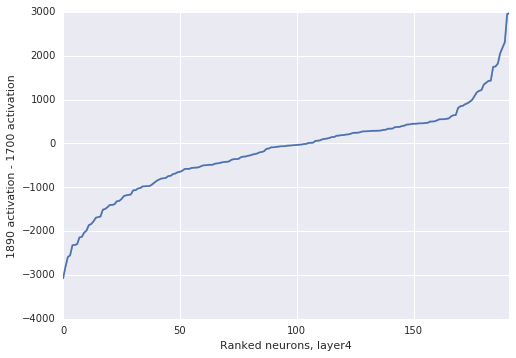

In [139]:
date_to_conv4_scores = pickle.load(open("/data/decorations_by_date/conv4_scores.pkl", 'r'))
diff_conv4 = date_to_conv4_arr["post-1890"] - date_to_conv4_arr["pre-1700"]
diff_conv4.sort_values(inplace=True)
sns.tsplot(diff_conv4)
plt.xlabel("Ranked neurons, layer4")
plt.ylabel("1890 activation - 1700 activation")

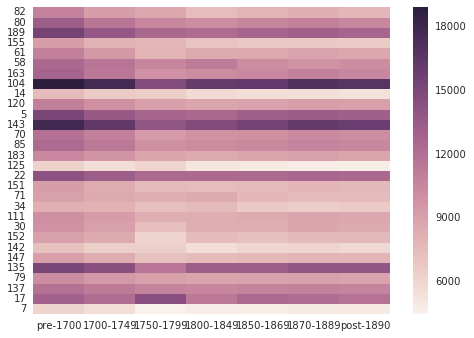

In [152]:
# heatmap it, rank neurons from low->high to high->low
date_to_conv4_arr = {}
for era in date_to_conv0_scores:
    date_to_conv4_arr[era] = pd.DataFrame.from_dict(date_to_conv4_scores[era]).mean(axis=1)
date_to_conv4_arr = pd.DataFrame.from_dict(date_to_conv4_arr)
date_to_conv4_arr = date_to_conv4_arr[labels_sorted]
sns.heatmap(date_to_conv4_arr.ix[diff_conv4.index[:30]])

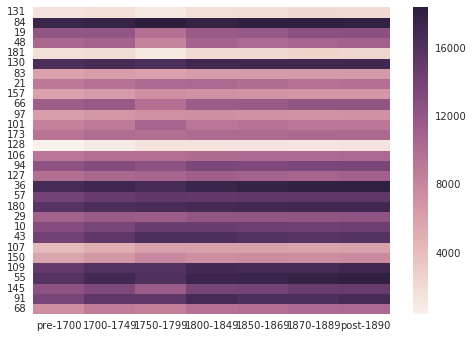

In [153]:
sns.heatmap(date_to_conv4_arr.ix[diff_conv4.index[-30:]])

## Mixed 5

In [142]:
date_to_mix5_scores = {}
mix5_tensor = sess.graph.get_tensor_by_name('mixed_5/join:0')

for era in date_to_images:
    print era
    date_to_mix5_scores[era] = {}

    for img in date_to_images[era]:
        idx = date_to_images[era][img]
        
        chk = idx/5000
        chunk = "Chunk" + str(chk)
        i = idx % 5000
        if chunk not in image_hdf5: continue

        a = [to_rgb(image_hdf5[chunk][i][:,:,0])]
        predictions = sess.run(mix5_tensor, {'ExpandDims:0': a})
        date_to_mix5_scores[era][img] = predictions.sum(axis=(0,1,2))

pickle.dump(date_to_mix5_scores, open("/data/decorations_by_date/mix5_scores.pkl", 'w'))

1870-1889
1750-1799
post-1890
pre-1700
1700-1749
1800-1849
1850-1869


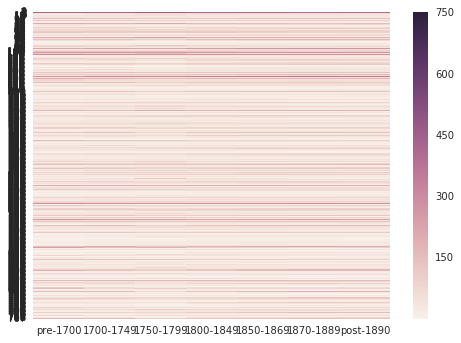

In [148]:
# heatmap it, rank neurons from low->high to high->low
date_to_mix5_scores = pickle.load(open("/data/decorations_by_date/mix5_scores.pkl", 'r'))
date_to_mix5_arr = {}
for era in date_to_conv0_scores:
    date_to_mix5_arr[era] = pd.DataFrame.from_dict(date_to_mix5_scores[era]).mean(axis=1)
date_to_mix5_arr = pd.DataFrame.from_dict(date_to_mix5_arr)
date_to_mix5_arr = date_to_mix5_arr[labels_sorted]
sns.heatmap(date_to_mix5_arr)

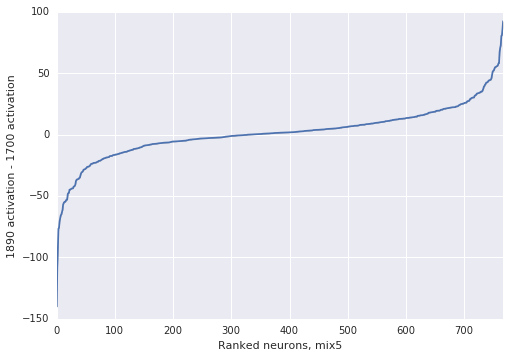

In [149]:
diff_mix5 = date_to_mix5_arr["post-1890"] - date_to_mix5_arr["pre-1700"]
diff_mix5.sort_values(inplace=True)
sns.tsplot(diff_mix5)
plt.xlabel("Ranked neurons, mix5")
plt.ylabel("1890 activation - 1700 activation")

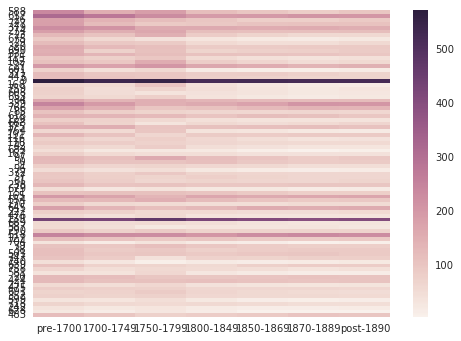

In [155]:
sns.heatmap(date_to_mix5_arr.ix[diff_mix5.index[:80]])

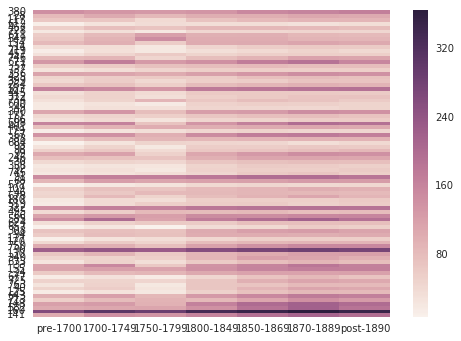

In [156]:
sns.heatmap(date_to_mix5_arr.ix[diff_mix5.index[-80:]])

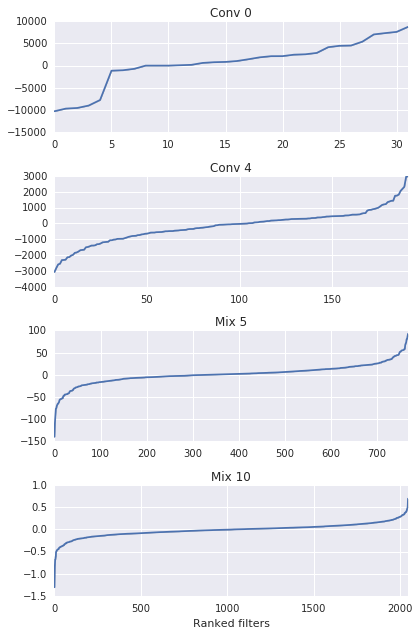

In [166]:
plt.figure(figsize=[6,9])
plt.subplot(411)
plt.title("Conv 0")
sns.tsplot(diff_conv0)
plt.subplot(412)
sns.tsplot(diff_conv4)
plt.title("Conv 4")
plt.subplot(413)
sns.tsplot(diff_mix5)
plt.title("Mix 5")
plt.subplot(414)
sns.tsplot(diff)
plt.title("Mix 10")
plt.xlabel("Ranked filters")
plt.tight_layout()